<a href="https://colab.research.google.com/github/IvanUlloa098/simulacion/blob/main/prueba_4/PRUEBA_SIMPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prueba SimPy
## Ivan Ulloa

In [1]:
!pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
import simpy
import random
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

In [45]:
MEDIA_REV = 20
STDD_REV = 10
CANT_PESADO=0.15 # cantidad de vehiculos pesados en la poblacion
PROB_PESADO=0.15
LLEGADA = 3
INT_ESTACIONAR = [3,5] 
INT_TURNO = [1,3] 
INT_PAG_MATR = [5,10] 
INT_SELLO = [1,3]
INT_SALIDA = [5,10]
DIAS = 30
TIEMPO_SIMULACION = DIAS * 8 * 60 # Se asume que la empresa abre por 8 horas cada dia

bernoulli = stats.bernoulli(CANT_PESADO)
distribucion = bernoulli.rvs(100) # Universo arbitrario

In [49]:
def tiempo_revision():
    return abs(random.normalvariate(MEDIA_REV, STDD_REV))

def vehiculo_pesado():
    contagios=stats.bernoulli(PROB_PESADO)
    return contagios.rvs(1)[0]

In [77]:
class RevisionVehicular(object):
    
    def __init__(self, environment, nombre):
        self.env=environment
        self.carril = simpy.Resource(environment, capacity=1)
        self.nombre = nombre
    
    def estacionar_vehiculo(self, vehiculo):
        yield self.env.timeout(random.randint(INT_ESTACIONAR[0], INT_ESTACIONAR[1]))

    def sacar_turno(self, vehiculo):
        yield self.env.timeout(random.randint(INT_TURNO[0], INT_TURNO[1]))
    
    def pagar_matricula(self, vehiculo):
        yield self.env.timeout(random.randint(INT_PAG_MATR[0], INT_PAG_MATR[1]))

    def pegar_sello(self, vehiculo):
        yield self.env.timeout(random.randint(INT_PAG_MATR[0], INT_PAG_MATR[1]))

    def salida_vehiculo(self, vehiculo):
        yield self.env.timeout(random.randint(INT_SALIDA[0], INT_SALIDA[1]))
        print(f'Salida del auto {vehiculo} del carril {self.nombre} TIEMPO={self.env.now}')

    def recurso_revision(self):
        with self.carril.request() as peticion:
          yield peticion   
          yield self.env.timeout(tiempo_revision())
          self.carril.release(peticion)       

def llegada_vehiculo(env, nombre, revision): 
    yield env.process(revision.estacionar_vehiculo(nombre))
    yield env.process(revision.sacar_turno(nombre))
    yield env.process(revision.pagar_matricula(nombre))
    yield env.process(revision.recurso_revision())
    yield env.process(revision.pegar_sello(nombre))
    yield env.process(revision.salida_vehiculo(nombre))

def ejecutar_simulacion_1(env, nombre):
    revision=RevisionVehicular(env, nombre)
    i=0
    
    while True:
        yield env.timeout(LLEGADA)
        print(f'Llegada del auto {i} del carril {nombre} TIEMPO={env.now}')
        i+=1
        proceso = [env.process(llegada_vehiculo(env, i, revision)), env.process(llegada_vehiculo(env, i, revision))]
        tiempo_1[env.now] = nombre
    
def ejecutar_simulacion_2(env, nombre):
    revision=RevisionVehicular(env, nombre)
    i=0
    
    while True:
        yield env.timeout(LLEGADA)
        print(f'Llegada del auto {i} del carril {nombre} TIEMPO={env.now}')
        i+=1
        proceso = [env.process(llegada_vehiculo(env, i, revision)), env.process(llegada_vehiculo(env, i, revision))]
        tiempo[env.now] = nombre

def ejecutar_simulacion_pesado(env, nombre):
    revision=RevisionVehicular(env, nombre)
    i=0
    
    while True:
        yield env.timeout(LLEGADA)
        print(f'Llegada del auto {i} del carril {nombre} TIEMPO={env.now}')
        i+=1
        if vehiculo_pesado() == 1:
          proceso = [env.process(llegada_vehiculo(env, i, revision)), env.process(llegada_vehiculo(env, i, revision))]
          tiempo[env.now] = nombre

In [78]:
tiempo={}
tiempo_1={}

env = simpy.Environment()
env.process(ejecutar_simulacion_1(env, 'carril 1'))
env.process(ejecutar_simulacion_2(env, 'carril 2'))
env.process(ejecutar_simulacion_pesado(env, 'carril 3'))

env.run(until = TIEMPO_SIMULACION)

Se han truncado las últimas 5000 líneas del flujo de salida.
Llegada del auto 3344 del carril carril 3 TIEMPO=10035
Salida del auto 1809 del carril carril 3 TIEMPO=10037.713822190137
Llegada del auto 3345 del carril carril 1 TIEMPO=10038
Llegada del auto 3345 del carril carril 2 TIEMPO=10038
Llegada del auto 3345 del carril carril 3 TIEMPO=10038
Salida del auto 1815 del carril carril 3 TIEMPO=10040.85243663074
Llegada del auto 3346 del carril carril 1 TIEMPO=10041
Llegada del auto 3346 del carril carril 2 TIEMPO=10041
Llegada del auto 3346 del carril carril 3 TIEMPO=10041
Salida del auto 247 del carril carril 1 TIEMPO=10041.208980304533
Llegada del auto 3347 del carril carril 1 TIEMPO=10044
Llegada del auto 3347 del carril carril 2 TIEMPO=10044
Llegada del auto 3347 del carril carril 3 TIEMPO=10044
Salida del auto 248 del carril carril 1 TIEMPO=10044.934086377894
Salida del auto 248 del carril carril 2 TIEMPO=10046.535629577022
Llegada del auto 3348 del carril carril 1 TIEMPO=10047
Lle

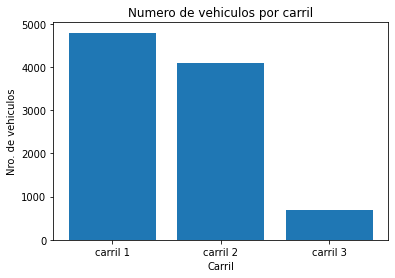

In [79]:
c1=0
c2=0
c3=0
carriles=['carril 1', 'carril 2', 'carril 3']

for key in tiempo:
  if tiempo[key] == carriles[1]:
    c2+=1 

  if tiempo[key] == carriles[2]:
    c3+=1 

for key in tiempo_1:
  c1+=1
     

plt.bar(carriles, [c1, c2, c3])
plt.title("Numero de vehiculos por carril")
plt.xlabel("Carril")
plt.ylabel("Nro. de vehiculos")
plt.show()

## Conclusiones
La gráfica nos muestra que el uso del carril 3 podría ser más eficiente y dar paso a otro vehículos realizando más revisiones en el día que manteniendolo cerrado completament. Puede utilizarse un sistema que de prioridad a los vehículos pesados sin dejar a los otros vehículos fuera de la posibilidad de realizar la revisión en esa plataforma.